In [7]:
import airline
import environment

import os
import ray
from ray import air, tune
from ray import tune
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.ddpg import DDPGConfig
from ray.rllib.algorithms.dqn import DQNConfig
from ray.rllib.env import PettingZooEnv
from ray.tune.registry import register_env
import multiprocessing


In [8]:
def simulate(n=300, action=airline.DEFAULT_POLICY):
    dfs = airline.get_df()
    print(airline.CONFIG)
    sim = airline.Simulator(airline.CONFIG, dfs, add_flights=True, save_history=True)

    actions = {x:action for x in sim.airports}
    # for i in range(30000):
    for i in range(n):
        sim.step()
    return sim.history

In [9]:
def chart(history):
    import pandas as pd
    data = { 
        i:{
            **{k:x[k] for k in ["incoming_count","incoming_delay","outgoing_count","outgoing_delay","policy"]},
            "landed_count":{k : len(v) for k,v in x["landed"].items()},
            "landed_delay":{k : sum(max(0,y["takeoff_ready"]-y["takeoff_plan"]) for y in v.values()) for k,v in x["landed"].items()},
        }
        for i, x in history.items() if (i != "current")
    }
    df = pd.Series({(k,kk,kkk):vvv for k,v in data.items() for kk, vv in v.items() for kkk, vvv in vv.items()}).unstack()

    df_RKSI = df["RKSI"].unstack()
    df_RKSI["policy"].plot()
    # (df_RKSI[["landed_delay"]].divide(df_RKSI[["landed_count"]].values+0.01)).plot()
    (df_RKSI[["incoming_delay","outgoing_delay"]].diff(6*24).divide(df_RKSI[["incoming_count","outgoing_count"]].diff(6*24).values+0.01)).plot()

{'std_delay': 10, 'buffer_time': 10, 'late_threshold': 15, 'holding_period': 120, 'timestep': 10, 'capacity': 10, 'num_plane': 100, 'num_iters': 30000, 'agent_airports': ['RKSI', 'RKSS', 'RKPK', 'RKPC', 'RKTN', 'RKTU', 'RKJB'], 'debug': False}


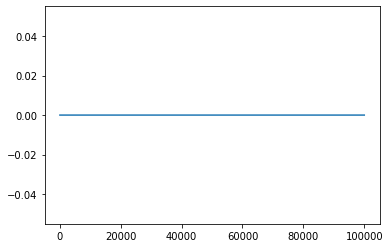

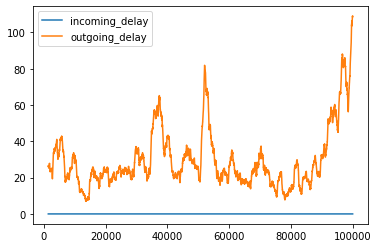

In [10]:
chart(simulate(n=10000, action=0))

{'std_delay': 10, 'buffer_time': 10, 'late_threshold': 15, 'holding_period': 120, 'timestep': 10, 'capacity': 10, 'num_plane': 100, 'num_iters': 30000, 'agent_airports': ['RKSI', 'RKSS', 'RKPK', 'RKPC', 'RKTN', 'RKTU', 'RKJB'], 'debug': False}


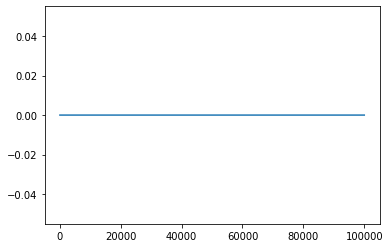

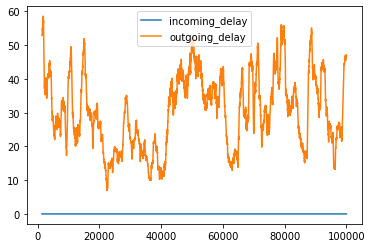

In [11]:
chart(simulate(n=10000, action=1))

{'std_delay': 10, 'buffer_time': 10, 'late_threshold': 15, 'holding_period': 120, 'timestep': 10, 'capacity': 10, 'num_plane': 100, 'num_iters': 30000, 'agent_airports': ['RKSI', 'RKSS', 'RKPK', 'RKPC', 'RKTN', 'RKTU', 'RKJB'], 'debug': False}


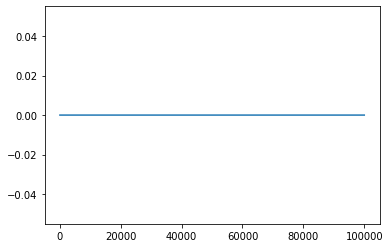

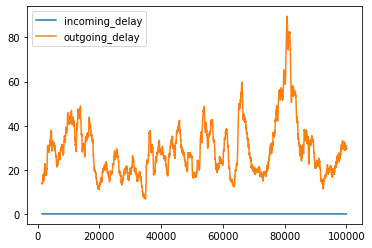

In [12]:
chart(simulate(n=10000, action=2))